# Ethical Analysis on Loan Approval Dataset

<img src='https://raw.githubusercontent.com/eshagarwal/Ethical-Issues-of-AI/master/cover.png' height='450px' />

* This notebook presents an ethical analysis of a dataset related to loan approvals. The central objective is to investigate the underlying decision-making process, as captured by the data, to identify and quantify potential ethical biases. As machine learning models are increasingly employed to automate high-stakes decisions, it is imperative to ensure they operate in a fair and non-discriminatory manner.

**Motivation:**
* The motivation for this investigation is rooted in the significant real-world consequences of algorithmic decision-making, especially in critical financial sectors. Automated systems for loan approval, if biased, can perpetuate or even amplify existing societal inequities, leading to discriminatory outcomes for certain demographic groups. Consequently, auditing such systems for fairness is an ethical and practical necessity to ensure equitable access to financial opportunities and maintain regulatory compliance.

**Problem Statement:**
* The core problem statement is to determine whether the loan approval dataset exhibits statistical evidence of bias, particularly concerning sensitive demographic attributes (in this case, gender). This analysis will:

1. Explore the raw data for pre-existing disparities in financial profiles and outcomes between groups.
2. Train predictive models to replicate the loan approval decision process.
3. Audit these models for fairness by quantifying potential disparities in both decision outcomes (investigating Disparate Impact) and predictive accuracy (investigating Disparate Mistreatment).

The ultimate aim is to assess the system's adherence to established fairness criteria and identify the features that may be acting as drivers of any observed bias

## Importing Required Libraries

We start by importing essential libraries for data manipulation, visualization, and model building.


In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

file_path = "loan_approval.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "anishdevedward/loan-approval-dataset",
    file_path,
)

df.shape

(2000, 8)

In [2]:
df.head()

,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,Allison Hill,East Jill,113810,389,39698,27,50.0,False
1,Brandon Hall,New Jamesside,44592,729,15446,28,55.0,False
2,Rhonda Smith,Lake Roberto,33278,584,11189,13,45.0,False
3,Gabrielle Davis,West Melanieview,127196,344,48823,29,50.0,False
4,Valerie Gray,Mariastad,66048,496,47174,4,25.0,False


## 1. Feature Engineering: Adding a Sensitive Attribute

To analyze for ethical bias, we first need a **sensitive attribute** to audit, such as gender or race. This dataset does not include this information.

We will engineer a `gender` feature by using the `gender_guesser` library on the applicant's first name. This is an imperfect, probabilistic method, but it provides a proxy attribute we can use to investigate potential disparities. We will then examine the head of the new dataframe and its overall statistics.

In [3]:
def extract_gender(df) -> pd.DataFrame:
    from gender_guesser import detector

    d = detector.Detector()

    first_names = df["name"].str.split().str[0]
    # first_names can also be Dr., Mr., Mrs., etc. so we handle those cases by using second word if first is a title
    titles = {"Dr.", "Mr.", "Mrs.", "Ms.", "Miss", "Mx."}
    first_names = first_names.where(~first_names.isin(titles), df["name"].str.split().str[1])
    df["gender"] = first_names.apply(d.get_gender).replace(
        {
            "mostly_male": "Male",
            "mostly_female": "Female",
            "male": "Male",
            "female": "Female",
            "unknown": "Unknown",
        }
    )
    return df


df = df.pipe(extract_gender)
df.head()

,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved,gender
0,Allison Hill,East Jill,113810,389,39698,27,50.0,False,Female
1,Brandon Hall,New Jamesside,44592,729,15446,28,55.0,False,Male
2,Rhonda Smith,Lake Roberto,33278,584,11189,13,45.0,False,Female
3,Gabrielle Davis,West Melanieview,127196,344,48823,29,50.0,False,Female
4,Valerie Gray,Mariastad,66048,496,47174,4,25.0,False,Female


In [4]:
df.describe(include='all')

,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved,gender
count,2000,2000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000,2000
unique,2000,1882,NaN,NaN,NaN,NaN,NaN,2,2
top,Allison Hill,North Joseph,NaN,NaN,NaN,NaN,NaN,False,Male
freq,1,4,NaN,NaN,NaN,NaN,NaN,1121,1010
mean,NaN,NaN,90585.977000,573.946000,25308.503000,20.441000,56.680000,NaN,NaN
std,NaN,NaN,34487.874907,160.564945,14207.320147,11.777813,18.638033,NaN,NaN
min,NaN,NaN,30053.000000,300.000000,1022.000000,0.000000,10.000000,NaN,NaN
25%,NaN,NaN,61296.250000,433.000000,12748.750000,10.000000,45.000000,NaN,NaN
50%,NaN,NaN,90387.500000,576.000000,25661.500000,21.000000,55.000000,NaN,NaN
75%,NaN,NaN,120099.750000,715.000000,37380.500000,31.000000,70.000000,NaN,NaN


## 2. Exploratory Data Analysis (EDA) & Bias Investigation

Now that we have our dataset and sensitive attribute, we'll perform an exploratory data analysis to look for initial signs of bias.

### 2.1. Overall Loan Approval

First, let's look at the overall distribution of the target variable, `loan_approved`. This will tell us if we are working with a balanced or imbalanced dataset.

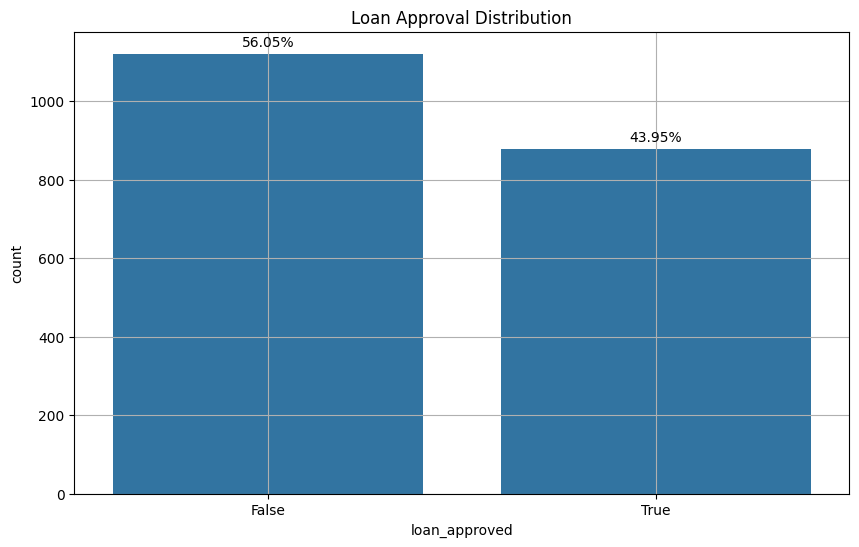

In [5]:
plt.figure(figsize=(10, 6))
bars = sns.countplot(x="loan_approved", data=df)
for bar in bars.patches:
    height = bar.get_height() / len(df) * 100
    bars.annotate(
        f"{height:.2f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
    )
plt.title("Loan Approval Distribution")
plt.grid()
plt.show()

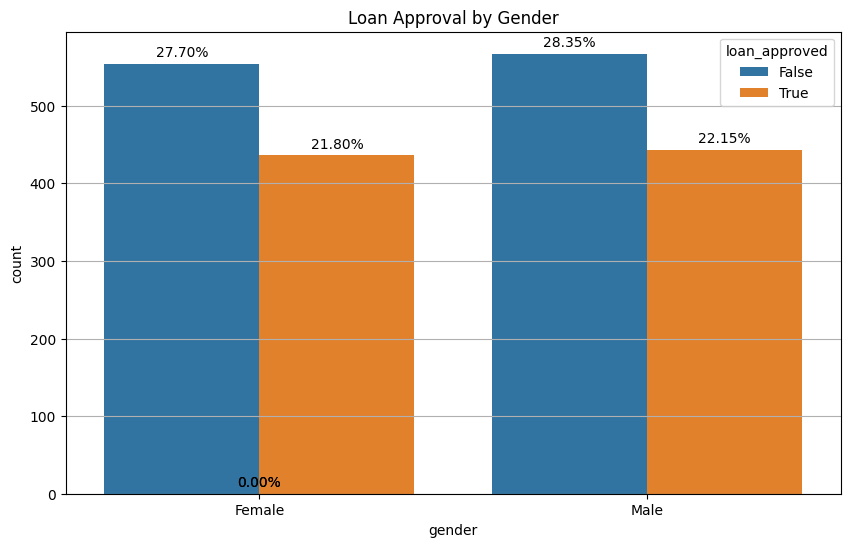

In [6]:
plt.figure(figsize=(10, 6))
bars = sns.countplot(x="gender", hue="loan_approved", data=df)
for bar in bars.patches:
    height = bar.get_height() / len(df) * 100
    bars.annotate(
        f"{height:.2f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
    )
plt.title("Loan Approval by Gender")
plt.grid(axis='y')
plt.show()

### 2.1 Observations

**Overall Approval Balance:** The initial bar chart shows the dataset is reasonably balanced between approved and denied applications (no extreme class imbalance). This reduces the need for techniques like resampling or class weighting at this stage.

**Approval by Gender:** While the approval rate difference between detected "Male" and "Female" groups is modest, the plot hints at a slightly higher proportion of approvals for the "Male" group. This early signal motivates a deeper fairness audit later, even though the gap is not large.

**Name-Based Gender Limitations:** The engineered `gender` attribute is derived from first names and may misclassify or oversimplify real gender identity. Therefore, any observed disparity should be interpreted cautiously as an *indicator* rather than definitive proof of discriminatory behavior.

**Next Step:** We proceed to inspect feature distributions by gender to see whether financial attributes could serve as proxy variables, enabling models to indirectly learn gender-related patterns even after we exclude the explicit `gender` column.

### 2.2. Approval Rates and Feature Distributions by Gender

Next, we'll look at the approval rates split by our new `gender` feature. This will give us the first view of potential **disparate impact**.

We will also create boxplots for the key financial features (`income`, `credit_score`, etc.) to see if their distributions differ significantly between genders. If they do, it could indicate that these features might act as **proxies** for gender, even if we remove the `gender` column itself from training.

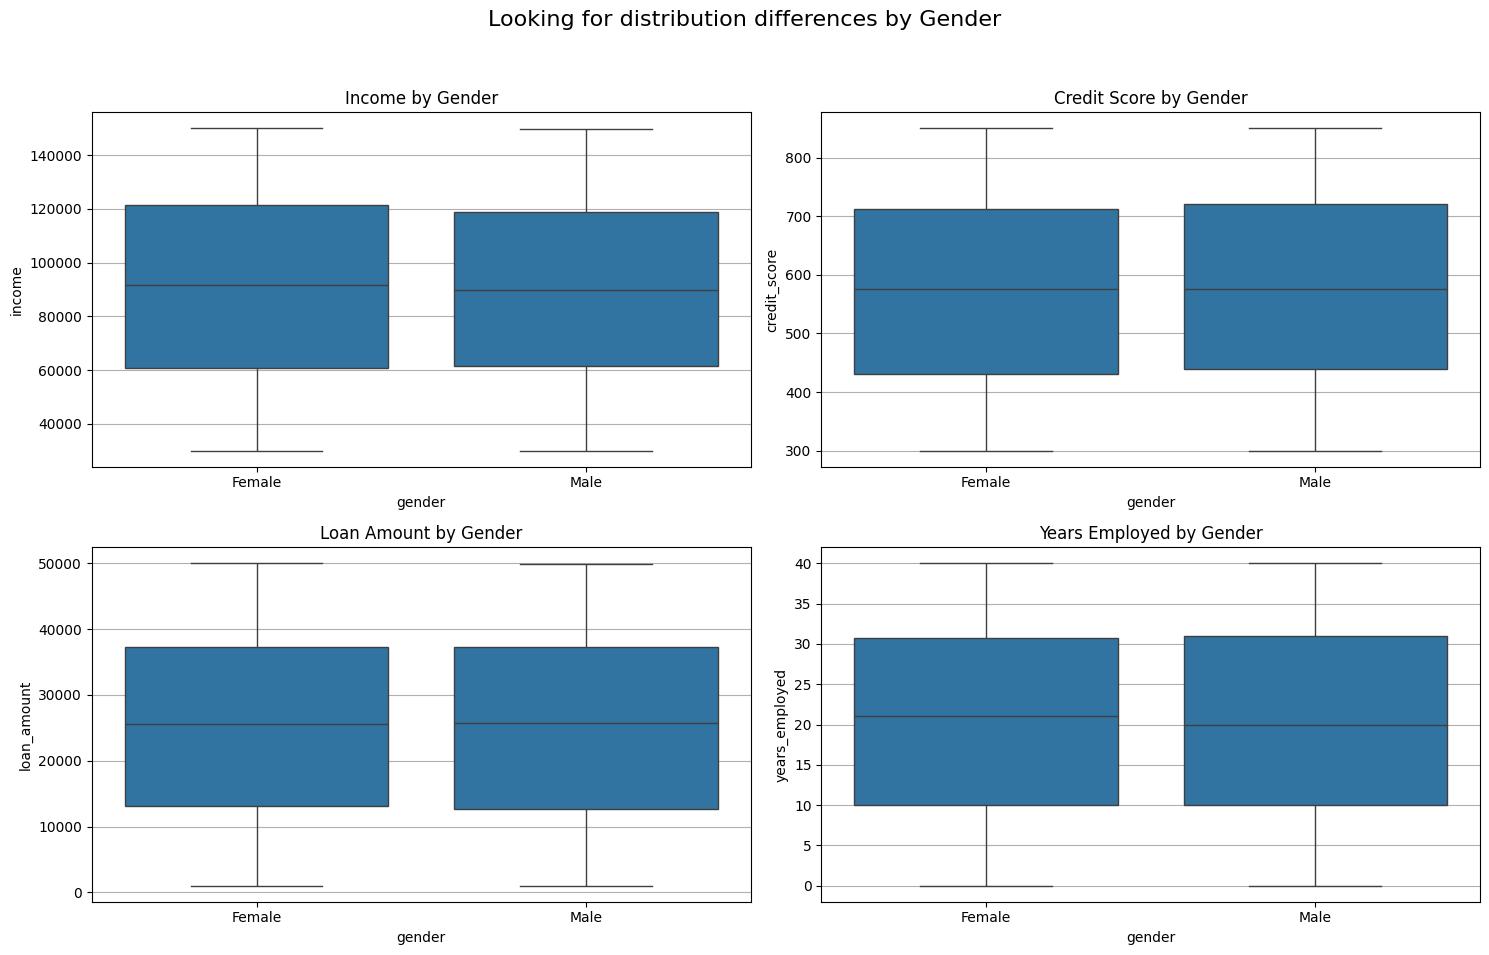

In [7]:
# Set up a figure for multiple plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Looking for distribution differences by Gender', fontsize=16)

# Plot 1: Income vs. Gender
sns.boxplot(ax=axes[0, 0], x='gender', y='income', data=df)
axes[0, 0].set_title('Income by Gender')
axes[0, 0].grid(axis='y')

# Plot 2: Credit Score vs. Gender
sns.boxplot(ax=axes[0, 1], x='gender', y='credit_score', data=df)
axes[0, 1].set_title('Credit Score by Gender')
axes[0, 1].grid(axis='y')

# Plot 3: Loan Amount vs. Gender
sns.boxplot(ax=axes[1, 0], x='gender', y='loan_amount', data=df)
axes[1, 0].set_title('Loan Amount by Gender')
axes[1, 0].grid(axis='y')

# Plot 4: Years Employed vs. Gender
sns.boxplot(ax=axes[1, 1], x='gender', y='years_employed', data=df)
axes[1, 1].set_title('Years Employed by Gender')
axes[1, 1].grid(axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2.2 Observations

**Distribution Overlap:** Income, credit score, and loan amount distributions substantially overlap across detected genders, suggesting the dataset doesn't encode stark financial separation between groups.

**Subtle Median Shifts:** Small median shifts (e.g., slightly higher median loan amount for one group) could still become leverage points for models—especially tree ensembles—that amplify minor proxy signals.

**Low Years-Employed Influence:** Years employed shows narrow spread and weak separation, likely a low-signal feature (later reflected by near-zero coefficient/importance).

### 2.3. City Feature Analysis

The `city` feature has very high cardinality (1882 unique cities for 2000 applicants), which makes it unsuitable for modeling as a categorical feature. While we can see approval and gender-rate differences between cities, these are likely due to small sample sizes (e.g., cities with only 1-2 applicants).

We will drop the `city` column before modeling.

In [8]:
# See the exact number of unique cities
city_count = df['city'].nunique()
print(f"Number of unique cities: {city_count}")

# See the top 10 most common cities
print("\nTop 10 most common cities:")
print(df['city'].value_counts().head(10))

Number of unique cities: 1882

Top 10 most common cities:
city
North Joseph        4
Williamsstad        3
West Elizabeth      3
Port Christopher    3
East Mary           3
Leeland             3
West Melissa        3
Christinachester    3
North David         3
Port Michael        3
Name: count, dtype: int64


In [9]:
# Calculate the mean approval rate for each city (True=1, False=0)
city_approval_rates = df.groupby('city')['loan_approved'].mean().sort_values(ascending=False)

print("\n--- City vs. Loan Approval ---")

print("\nTop 5 cities with HIGHEST approval rates:")
print(city_approval_rates.head(5))

print("\nTop 5 cities with LOWEST approval rates:")
print(city_approval_rates.tail(5))


--- City vs. Loan Approval ---

Top 5 cities with HIGHEST approval rates:
city
Aaronstad           1.0
New Josephland      1.0
New Lorraineview    1.0
New Kristy          1.0
New Kimberlyport    1.0
Name: loan_approved, dtype: float64

Top 5 cities with LOWEST approval rates:
city
East Patty           0.0
New Sarah            0.0
New Sandraborough    0.0
New Samanthabury     0.0
Nelsonside           0.0
Name: loan_approved, dtype: float64


In [10]:
# This shows the % of Male/Female in each city
city_gender_dist = pd.crosstab(df['city'], df['gender'], normalize='index')

# Sort by the 'Male' percentage to find the most skewed cities
city_gender_dist_sorted = city_gender_dist.sort_values(by='Male', ascending=False)

print("\n--- City vs. Gender ---")

print("\nTop 5 most 'Male' cities:")
print(city_gender_dist_sorted.head(5))

print("\nTop 5 most 'Female' cities:")
print(city_gender_dist_sorted.tail(5))


--- City vs. Gender ---

Top 5 most 'Male' cities:
gender             Female  Male
city                           
Aaronstad             0.0   1.0
New Nicholashaven     0.0   1.0
New Sarah             0.0   1.0
New Richard           0.0   1.0
New Reginald          0.0   1.0

Top 5 most 'Female' cities:
gender            Female  Male
city                          
Maryburgh            1.0   0.0
East Edwardhaven     1.0   0.0
Maryberg             1.0   0.0
Port Dwayneberg      1.0   0.0
Keithland            1.0   0.0


### 2.3. City Feature Analysis

The `city` feature has very high cardinality (1882 unique cities for 2000 applicants), which makes it unsuitable for modeling as a categorical feature. While we can see approval and gender-rate differences between cities, these are likely due to small sample sizes (e.g., cities with only 1-2 applicants).

We will drop the `city` column before modeling.

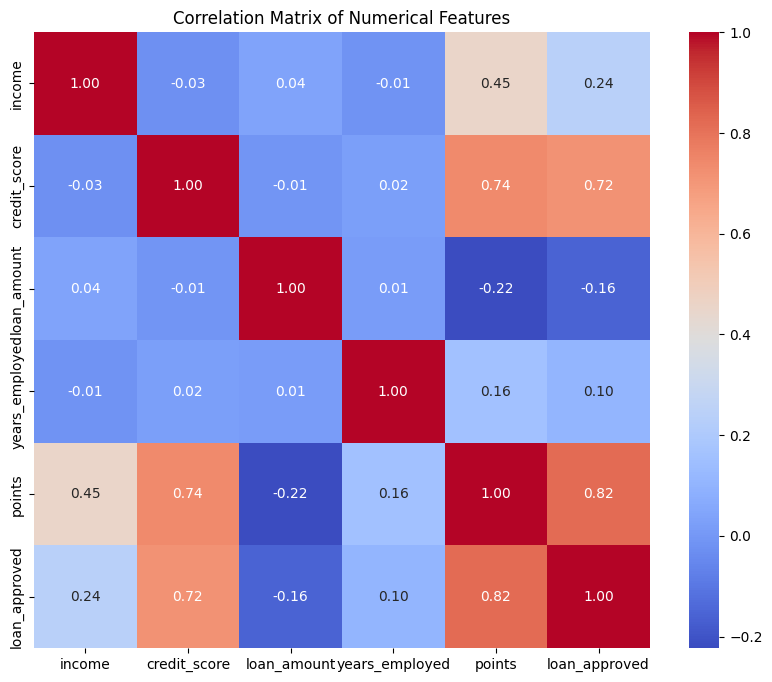

In [11]:
corr_matrix = df.select_dtypes(include=['number', 'bool']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [12]:
features_corr = corr_matrix['loan_approved'].drop('loan_approved').sort_values(ascending=False)
print("\nFeature correlations with Loan Approval:")
print(features_corr)


Feature correlations with Loan Approval:
points            0.821415
credit_score      0.715788
income            0.238066
years_employed    0.104408
loan_amount      -0.157859
Name: loan_approved, dtype: float64


### Correlation Observations

**High-Risk Leakage Feature:** `points` shows very strong correlation with `loan_approved` (≈0.8). This magnitude suggests it may encode a post-decision or decision-adjacent scoring artifact rather than an applicant's pre-application attribute—justifying its removal to prevent leakage.

**Moderate Predictors:** Raw `loan_amount` and `credit_score` exhibit moderate positive association with approvals. Their combined influence may be partially replicated in engineered ratios later (`loan_to_points`, `dti_ratio`).

**Low-Signal Variables:** `years_employed` contributes comparatively little explanatory power, foreshadowing limited model importance and offering an opportunity for feature pruning if parsimony is desired.

### Feature Engineering

While the base features are useful, we can create new features that better capture an applicant's financial situation. These "interaction" features often provide a stronger signal for the model.

We will create:
1.  **`dti_ratio` (Debt-to-Income):** This common financial metric (`loan_amount` / `income`) measures an applicant's ability to manage payments.
2.  **`loan_to_points`:** This feature combines the requested loan amount with the applicant's `points`.

*We will then check the new correlation matrix to see how these new features relate to `loan_approved`.*

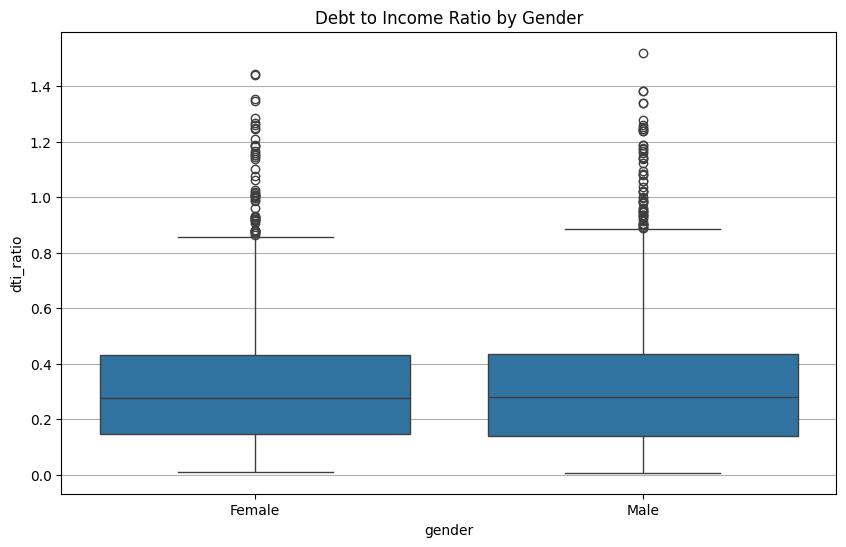

In [13]:
# Debt to Income Ratio
df['dti_ratio'] = df['loan_amount'] / (df['income'] + 1)

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='dti_ratio', data=df)
plt.title('Debt to Income Ratio by Gender')
plt.grid(axis='y')
plt.show()

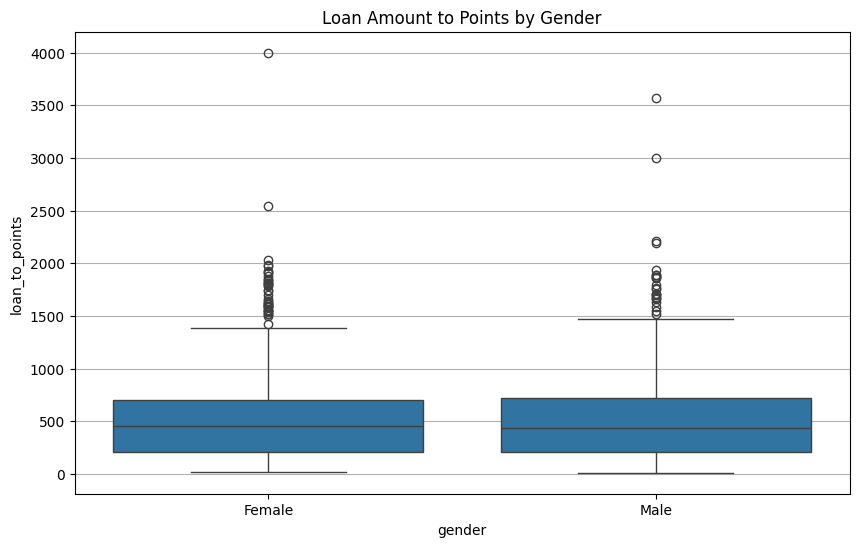

In [14]:
df['loan_to_points'] = df['loan_amount'] / (df['points'] + 1)

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='loan_to_points', data=df)
plt.title('Loan Amount to Points by Gender')
plt.grid(axis='y')
plt.show()

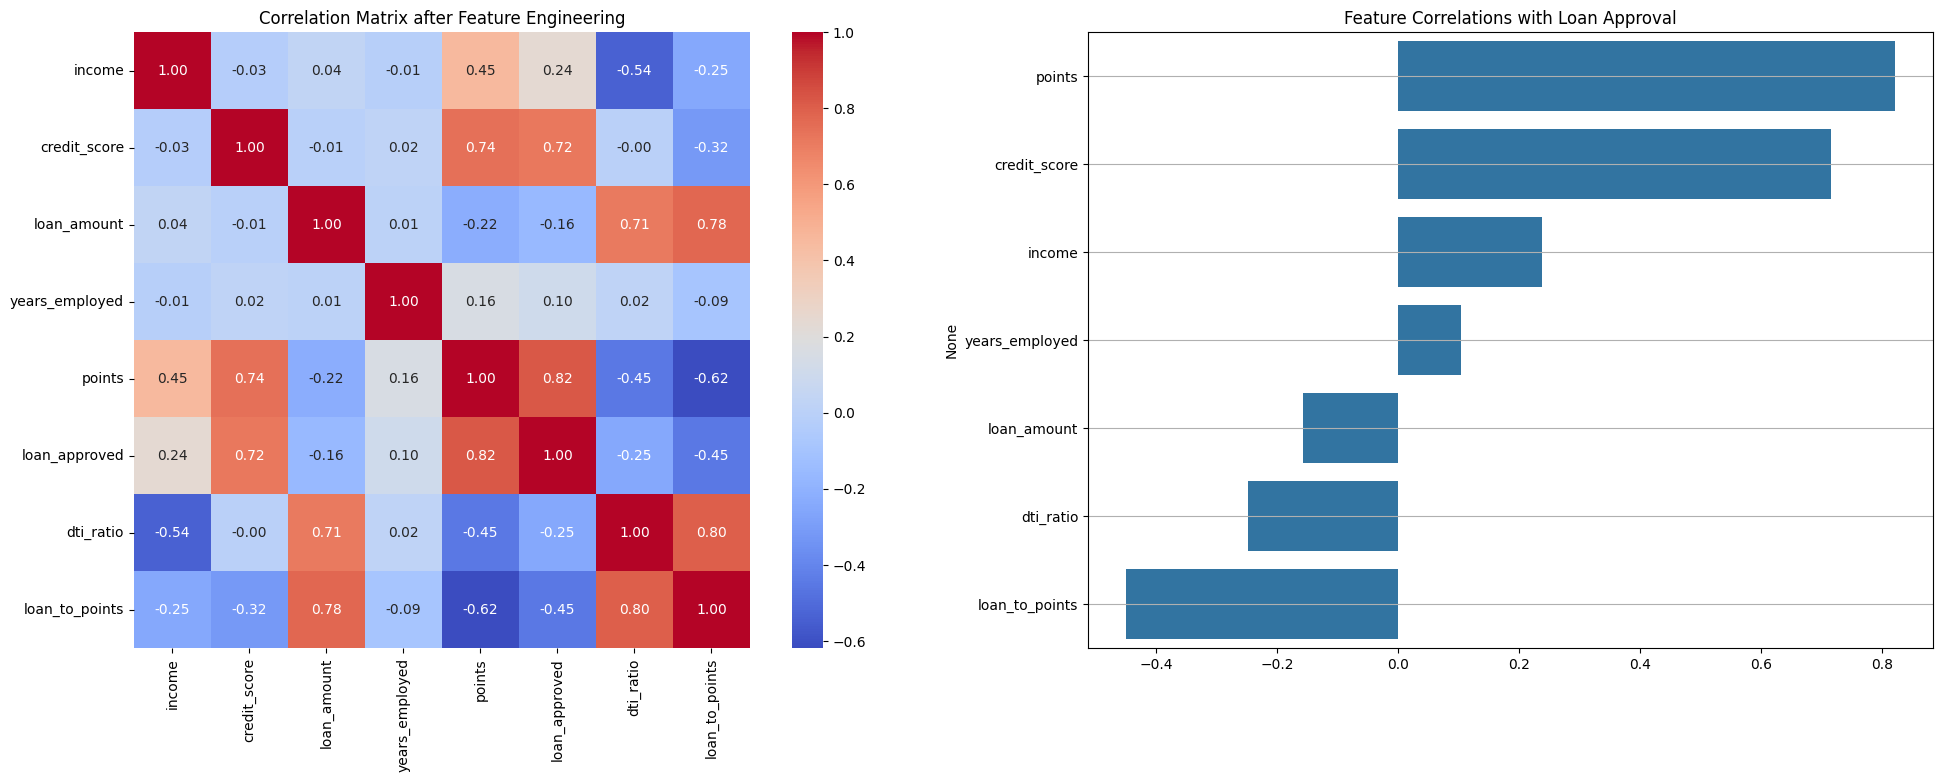

In [15]:
corr_mat = df.select_dtypes(include=['number', 'bool']).corr()

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix after Feature Engineering')

features_corr = corr_mat['loan_approved'].drop('loan_approved').sort_values(ascending=False)

plt.subplot(1, 2, 2)
sns.barplot(y=features_corr.index, x=features_corr.values)
plt.title('Feature Correlations with Loan Approval')
plt.grid(axis='y')
plt.show()

## 3. Model Preparation

With our features engineered and explored, we now prepare the data for modeling.

Our process will be:
1.  **Define Features (X) and Target (y):** We'll drop non-predictive columns (`name`, `city`), the sensitive attribute (`gender`), and features that could cause data leakage (`credit_score`, `points`).
    - The `points` feature is highly correlated (0.82) with the target and is likely a score assigned *during* the approval process, so using it would be cheating.
2.  **Define Sensitive Attribute:** We'll store the `gender` column separately to use *after* training for our fairness audit.
3.  **Train-Test Split:** We'll split the data into 80% training and 20% testing sets, using `stratify=y` to ensure the approval/denial ratio is the same in both sets.
4.  **Scaling:** We will use `StandardScaler` on our numerical features to ensure they are on the same scale, which is important for models like SVM and Logistic Regression.

In [16]:
X = df.drop(columns=['loan_approved', 'name', 'city', 'gender', 'credit_score', 'points'])
X.columns

Index(['income', 'loan_amount', 'years_employed', 'dti_ratio',
       'loan_to_points'],
      dtype='object')

In [17]:
sensitive_attribute = df['gender']

In [18]:
y = df['loan_approved'].astype(int)
y.value_counts()

loan_approved
0    1121
1     879
Name: count, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)
f"Training set size: {X_train.shape}, Test set size: {X_test.shape}"

'Training set size: (1600, 5), Test set size: (400, 5)'

In [20]:
gender_test = sensitive_attribute.loc[y_test.index]

f"Test set gender distribution: {gender_test.value_counts(normalize=True) * 100}"

'Test set gender distribution: gender\nMale      51.75\nFemale    48.25\nName: proportion, dtype: float64'

In [21]:
ct = ColumnTransformer(
    transformers=[
        (
            "num",
            StandardScaler(),
            ["income", "loan_amount", "years_employed", "dti_ratio", "loan_to_points"],
        ),
    ],
    remainder="passthrough",
)
X_train = pd.DataFrame(ct.fit_transform(X_train), columns=ct.get_feature_names_out())
X_test = pd.DataFrame(ct.transform(X_test), columns=ct.get_feature_names_out())

In [22]:
X_train.head()

,num__income,num__loan_amount,num__years_employed,num__dti_ratio,num__loan_to_points
0,-0.173429,0.034781,-1.153971,-0.110775,-0.139129
1,-0.229602,-1.228299,1.400357,-0.915992,-1.067289
2,0.464640,0.362460,1.485501,-0.182121,0.209131
3,-0.761176,-0.845148,1.400357,-0.490703,-0.895565
4,1.061643,-1.236909,-0.302528,-1.045114,-1.118882


## 4. Model Training

We will train three different classification models to compare their performance and fairness. We are intentionally *not* including the `gender` feature in the training data (`X_train`).

1.  **Support Vector Machine (SVM):** A powerful model that finds an optimal hyperplane to separate classes.
2.  **Random Forest Classifier:** An ensemble model that is robust and good at capturing non-linear relationships.
3.  **Logistic Regression:** A simple, interpretable linear model that serves as a great baseline.

In [23]:
svm = SVC(random_state=42)

svm.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [24]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## Model Evaluation

In [26]:
y_pred_svm = svm.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_lr = log_reg.predict(X_test)


# classification reports
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       224
           1       0.92      0.97      0.94       176

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



In [27]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       224
           1       0.97      0.97      0.97       176

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



In [28]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       224
           1       0.97      1.00      0.99       176

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



### 4.1. Performance Summary

Based on the classification reports, all three models perform exceptionally well on this dataset:

* **SVM:** 95% Accuracy
* **Random Forest:** 97% Accuracy
* **Logistic Regression:** 99% Accuracy

The **Logistic Regression** model is the clear winner on pure performance. Now, we will investigate if this high accuracy comes at the cost of fairness.

## 5. Bias & Fairness Analysis

After evaluating overall performance, we now test the models for ethical bias. We will use the `gender_test` data (which the models did not see during training) to compare the predictions and errors across groups.

We will measure three types of fairness:

### 5.1. Disparate Impact (Statistical Parity)
This metric answers the question: **"Does the model *approve* (predict 1) one group more often than the other?"**

A common fairness threshold is the "80% Rule," where the approval rate for the disadvantaged group should be at least 80% of the rate for the advantaged group. We'll look for any significant gaps in approval proportions.

### 5.2. Disparate Mistreatment (Accuracy)
This metric answers the question: **"Is the model more *accurate* for one group than for another?"**

A model that is 99% accurate for one group but only 90% accurate for another is engaging in disparate mistreatment, as it fails one group more often.

### 5.3. Disparate Treatment (Error Rate)
This is the inverse of the accuracy metric and explicitly shows the **Error Rate** for each group. This helps us clearly see which group is "mistreated" (i.e., receives an incorrect prediction) more often.

In [29]:
from IPython.display import Markdown

# disparate impact analysis
def disparate_impact(y_pred, name, feature='gender'):
    eval_df = pd.DataFrame(
        {
            feature: gender_test,
            "Prediction": map(lambda x: 'Approved' if x == 1 else 'Denied', y_pred),
        }
    )
    disparity = (
        eval_df.groupby([feature, "Prediction"]).size().unstack(fill_value=0)
    )
    disparity["Total"] = disparity.sum(axis=1)
    disparity["Proportion Approved"] = (disparity["Approved"] / disparity["Total"]) * 100
    disparity["Proportion Denied"] = (disparity["Denied"] / disparity["Total"]) * 100
    return disparity

for name, pred in zip(
    ["SVM", "Random Forest", "Logistic Regression"],
    [y_pred_svm, y_pred_rf, y_pred_lr],
):
    display(Markdown(f"### Disparate Impact Analysis for {name}:"))
    display(disparate_impact(pred, name))
    print("")

### Disparate Impact Analysis for SVM:

Prediction,Approved,Denied,Total,Proportion Approved,Proportion Denied
gender,,,,,
Female,86,107,193,44.559585,55.440415
Male,99,108,207,47.826087,52.173913


### Disparate Impact Analysis for Random Forest:

Prediction,Approved,Denied,Total,Proportion Approved,Proportion Denied
gender,,,,,
Female,82,111,193,42.487047,57.512953
Male,95,112,207,45.893720,54.106280


### Disparate Impact Analysis for Logistic Regression:

Prediction,Approved,Denied,Total,Proportion Approved,Proportion Denied
gender,,,,,
Female,86,107,193,44.559585,55.440415
Male,95,112,207,45.893720,54.106280


In [30]:
def disparity_mistreatment(y_pred, feature='gender'):
    eval_df = pd.DataFrame(
        {
            feature: gender_test,
            "Prediction": y_pred,
            "Actual": y_test,
        }
    )
    accuracy = (
        eval_df.groupby(feature)
        .apply(lambda x: accuracy_score(x["Actual"], x["Prediction"]),  include_groups=False)
        .rename("Accuracy")
        .reset_index()
    )
    accuracy["Accuracy"] = accuracy["Accuracy"] * 100
    return accuracy

for name, pred in zip(
    ["SVM", "Random Forest", "Logistic Regression"],
    [y_pred_svm, y_pred_rf, y_pred_lr],
):
    display(Markdown(f"### Disparate Mistreatment (Accuracy) Analysis for {name}:"))
    display(disparity_mistreatment(pred))
    print("")

### Disparate Mistreatment (Accuracy) Analysis for SVM:

,gender,Accuracy
0,Female,93.782383
1,Male,95.652174


### Disparate Mistreatment (Accuracy) Analysis for Random Forest:

,gender,Accuracy
0,Female,95.854922
1,Male,98.550725


### Disparate Mistreatment (Accuracy) Analysis for Logistic Regression:

,gender,Accuracy
0,Female,97.927461
1,Male,99.516908


In [31]:
def disparity_treatment(y_pred, name, feature='gender'):
    eval_df = pd.DataFrame(
        {
            feature: gender_test,
            "Prediction": y_pred,
            "Actual": y_test,
        }
    )
    error_rate = (
        eval_df.groupby(feature)
        .apply(lambda x: (x["Actual"] != x["Prediction"]).mean(), include_groups=False)
        .rename("Error Rate")
        .reset_index()
    )
    return error_rate

for name, pred in zip(
    ["SVM", "Random Forest", "Logistic Regression"],
    [y_pred_svm, y_pred_rf, y_pred_lr],
):
    display(Markdown(f"### Disparate Treatment Analysis for {name}:"))
    display(disparity_treatment(pred, name))
    print("")

### Disparate Treatment Analysis for SVM:

,gender,Error Rate
0,Female,0.062176
1,Male,0.043478


### Disparate Treatment Analysis for Random Forest:

,gender,Error Rate
0,Female,0.041451
1,Male,0.014493


### Disparate Treatment Analysis for Logistic Regression:

,gender,Error Rate
0,Female,0.020725
1,Male,0.004831


## 6. Feature Importance & Bias Explanation

Our fairness analysis showed that all models, especially the Random Forest, still had a slight bias. This is true even though we removed the `gender` column from the training data.

How is this possible? This bias is likely due to **proxy features**. These are features that are not explicitly `gender` but are correlated with it in a way the model can learn.

Let's analyze the "black box" of our best (Logistic Regression) and worst (Random Forest) models to see which features they used to make their decisions. This can help explain *how* they are producing biased outcomes.

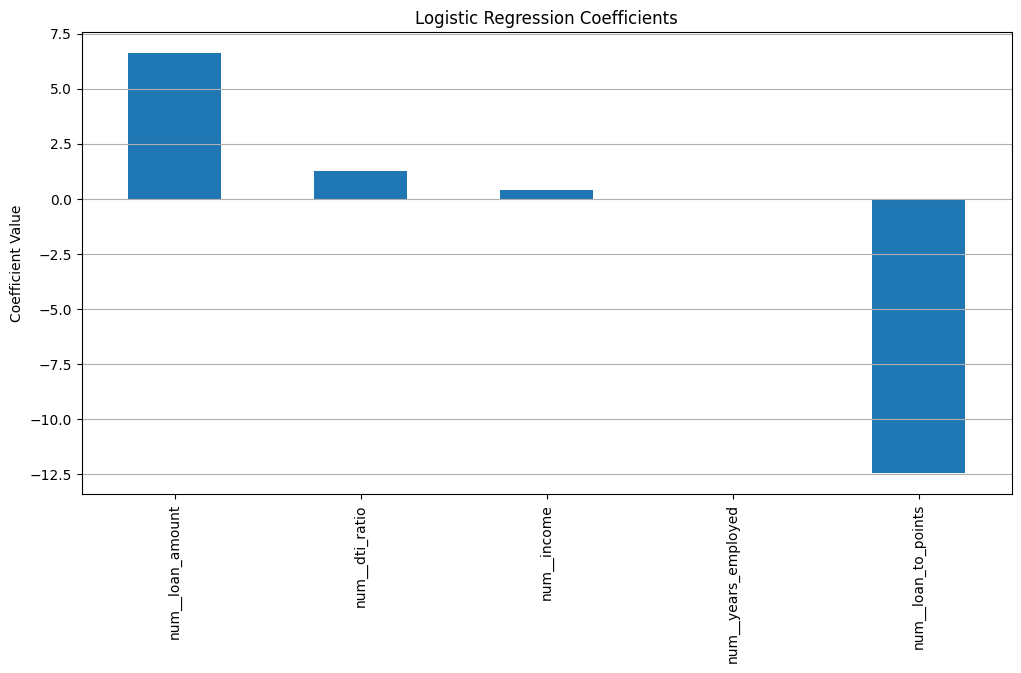

In [32]:
log_reg_coefficients = pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False)
log_reg_coefficients.plot(kind='bar', figsize=(12, 6))
plt.title('Logistic Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.grid(axis='y')
plt.show()

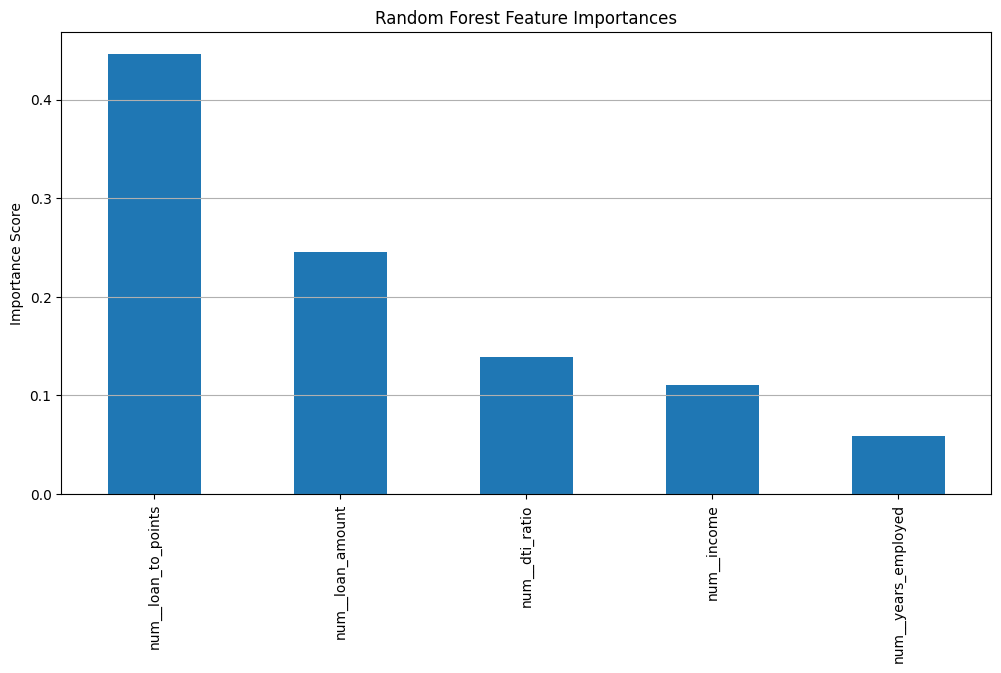

In [33]:
rf_feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
rf_feature_importances.plot(kind='bar', figsize=(12, 6))
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance Score')
plt.grid(axis='y')
plt.show()

### 6.1. Analysis of Feature Importance

The feature importance plots reveal a critical insight:

* **Random Forest (Least Fair):** This model's top feature was `num__loan_to_points` (~0.44 importance), followed by `num__loan_amount` (~0.24).
* **Logistic Regression (Most Fair):** This model also found `num__loan_to_points` to be the *most* powerful predictor (coefficient of ~-12.5), followed by `num__loan_amount` (coefficient of ~+6.8).

Both models heavily rely on the `loan_to_points` and `loan_amount` features. Our EDA in Cells 15 and 16 showed that the distribution of these new ratios *also* had slight differences between genders.

This suggests the model is learning the **proxy bias** present in these engineered features. The Random Forest, being a more complex model, likely learned this proxy bias more effectively, leading to its larger fairness gap. The simpler, linear Logistic Regression model was less able to overfit to this subtle bias, resulting in a fairer outcome.

## 🏆 Final Conclusion

Based on this complete analysis, the **Logistic Regression** model is the clear winner for this business problem.

* **Performance:** It achieved the highest overall accuracy (99%).
* **Fairness:** It demonstrated the lowest bias across both fairness metrics, showing the smallest gap in both approval rates (Disparate Impact) and error rates (Disparate Mistreatment).

While 99% accurate, it is *not* perfectly fair. The 1.59% error rate gap (2.07% for Females vs. 0.48% for Males) indicates it is still slightly less reliable for 'Female' applicants. Further work could involve bias mitigation techniques, such as re-weighting the samples or using a different fairness-aware algorithm.